In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
assert tf.__version__.startswith('2'), "upgrade TensorFlow version to TensorFlow 2"
from skimage.io import imread

from utils import show, show_multiple
from utils import get_splitted_data_with_size, plot_model_history, scale_data, apply_scaling

### Unzip the data on disk

In [2]:
if not os.path.exists('data/cat/'):
    print('Extracting cat image files...')
    zf = zipfile.ZipFile('data/cat.zip')
    zf.extractall('data/')
if not os.path.exists('data/dog/'):
    print('Extracting dog image files...')
    zf = zipfile.ZipFile('data/dog.zip')
    zf.extractall('data/')

# I - Introduction to Tensorflow and convolution filters

<img src="../images/standard_vs_depthwise_conv.png" style="width: 850px;"/>

**- Left: standard convolution, the whole kernel is parsing the input tensor for each output channel dimension**

**- Right: depthwise convolution, each slide of the kernel is parsing each input dimension. The result is constructed afterward using a concatenation of the feature maps. That is particularly useful to retrieve a valid RGB image**

#### Sample image example

In [3]:
sample_image = imread("data/panda.jpg")
sample_image = tf.cast(sample_image, tf.float32)  # we will cast it as a tensorflow EagerTensor

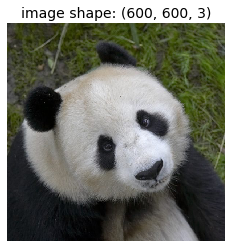

In [4]:
show(sample_image.numpy())

### I - A) Simple box blur kernel

#### 2d convolution with tensorflow:
- https://www.tensorflow.org/api_docs/python/tf/nn/depthwise_conv2d
- https://www.tensorflow.org/api_docs/python/tf/nn/conv2d

In [5]:
def conv_2d(x, k, strides, padding, conv_type):
    if conv_type == 'depthwise':
        return tf.nn.depthwise_conv2d(
            x, k, strides=strides, padding=padding
        )
    elif conv_type == 'standard':
        return tf.nn.conv2d(
            x, k, strides=strides, padding=padding
        )   

In [6]:
def visualize_kernel(kernel):
    # move the channel dimension to the first one
    # this way, it is easier to see the spacial organization of the kernel with print
    print(np.transpose(kernel, (2, 0, 1)))

In [7]:
kernel_data = np.ones(shape=(5, 5, 3)).astype(np.float32)
kernel_data = tf.divide(kernel_data, tf.reduce_sum(kernel_data, axis=[0, 1]))
visualize_kernel(kernel_data)

[[[0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]]

 [[0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]]

 [[0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]]]


Kernel shape: (5, 5, 3, 1)


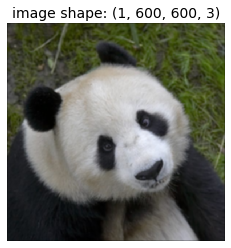

In [8]:
image_batch_expanded = tf.expand_dims(sample_image, axis=0)
kernel_data_expanded = tf.expand_dims(kernel_data, axis=-1)
print('Kernel shape: %s' % str(kernel_data_expanded.shape))
output_image = conv_2d(
    image_batch_expanded, 
    kernel_data_expanded, 
    strides=(1, 1, 1, 1), 
    padding='SAME', conv_type='depthwise'
)
feature_map = output_image.numpy()
show(feature_map)

**Questions**
- Explain what happened here: what transformation has been applied to the image?

<span style="color:green">
Each kernel weight has the value $\frac{1}{height \cdot width}$.<br/>
Applying a 2D convolution with it will have an averaging effect: each value in the outputted feature map will be the average of the neighboring pixels in the input image.<br/>
This transformation in particular is called a box blur filter.
</span>

### I - B) Identity kernel

In [9]:
kernel_data = np.zeros(shape=(3, 3, 3)).astype(np.float32)
kernel_data[1, 1, :] = 1
visualize_kernel(kernel_data)

[[[0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]]]


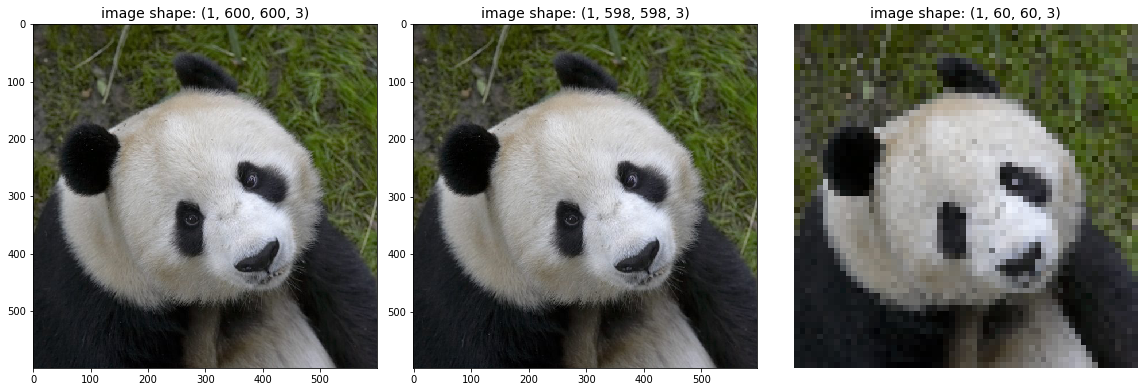

In [10]:
image_batch_expanded = np.expand_dims(sample_image, axis=0)
kernel_data_expanded = np.expand_dims(kernel_data, axis=-1)
features_map = []
for padding, strides in [
    ('SAME', (1, 1, 1, 1)), ('VALID', (1, 1, 1, 1)), ('SAME', (1, 10, 10, 1))
]:
    feature_map = conv_2d(
        image_batch_expanded, kernel_data_expanded, 
        strides=strides, 
        padding=padding, 
        conv_type='depthwise'
    )
    features_map.append(feature_map.numpy())
show_multiple(features_map, figsize=(16, 12))

**Questions**
- Try to modify the strides and the padding type. What are the effects on the final output?

<ul>
<li style="color:green">
Stride is the number of pixels with which we slide our filter, horizontally or vertically, while applying our convolution products. Increasing it has for main effect to decrease the final output size: in our case, having a $(10, 10)$ slide divides the final image shape by a factor of $10$ horizontally and $10$ vertically.<br/>
<li style="color:green">In addition, we can choose different padding types.<br/> 
The parameter 'SAME' results in an identical output shape for a minimal stride size, with $0$ values virtually added to the edges of the image proportionally to the kernel size.<br/> 
On the other hand, the parameter 'VALID' will lead to convolution operations being performed only if the kernel lies entirely over the image, contrary to the case with padding.
For instance, a convolution layer with (1,1) stride and this parameter will lead the final output size to have $K - 1$ fewer elements along both dimensions.
</ul>

### I - C) Line detection kernel on greyscale transformed image

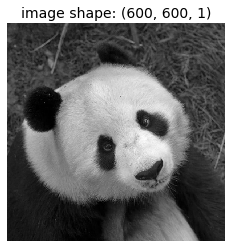

In [11]:
grey_sample_image = tf.expand_dims(tf.reduce_sum(sample_image, axis=2) / 3., axis=-1)
show(grey_sample_image.numpy())

**Exercice**

Try to implement a kernel that does line or edge detection:
- https://en.wikipedia.org/wiki/Kernel_(image_processing)
- https://en.wikipedia.org/wiki/Sobel_operator

In [12]:
line_detection_kernel_x = np.asarray(
    [
        [1, 0., -1],
        [2, 0., -2],
        [1, 0., -1]
    ]
)

line_detection_kernel_y = np.asarray(
    [
        [1,   2,  1],
        [0.,  0., 0.],
        [-1, -2,  -1]
    ]
)

kernel_data_x = tf.expand_dims(line_detection_kernel_x, axis=-1)
kernel_data_y = tf.expand_dims(line_detection_kernel_y, axis=-1)
print('Vertical edges detection kernel:')
visualize_kernel(kernel_data_x)
print('Horizontal edges detection kernel:')
visualize_kernel(kernel_data_y)

Vertical edges detection kernel:
[[[ 1.  0. -1.]
  [ 2.  0. -2.]
  [ 1.  0. -1.]]]
Horizontal edges detection kernel:
[[[ 1.  2.  1.]
  [ 0.  0.  0.]
  [-1. -2. -1.]]]


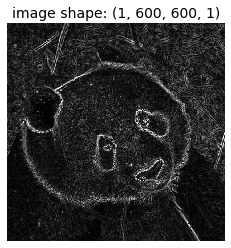

In [13]:
image_batch = tf.expand_dims(grey_sample_image, axis=0)
features_map = []
for kernel in [kernel_data_x, kernel_data_y]:
    kernel_expanded = tf.cast(tf.expand_dims(kernel, axis=-1), tf.float32)
    output_line_detection = conv_2d(
        image_batch, kernel_expanded,
        strides=(1, 1, 1, 1), 
        padding='SAME', 
        conv_type='standard'
    )
    features_map.append(output_line_detection)
feature_map = tf.sqrt(tf.reduce_sum(tf.square(features_map), axis=0))
show(feature_map.numpy())

### I - D) Max and average pooling

**Exercice**

Now apply a Max Pooling and an Average Pooling operations on our image.<br/>
- https://www.tensorflow.org/api_docs/python/tf/nn/max_pool
- https://www.tensorflow.org/api_docs/python/tf/nn/avg_pool

Again, try to make fluctuate the `ksize` and `strides` parameters

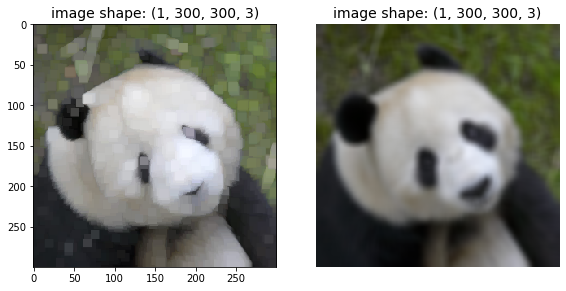

In [14]:
image_batch_expanded = np.expand_dims(sample_image, axis=0)

output_max_pool = tf.nn.max_pool(
    image_batch_expanded, ksize=[1, 20, 20, 1], strides=[1, 2, 2, 1], padding='SAME'
)
output_avg_pool = tf.nn.avg_pool(
    image_batch_expanded, ksize=[1, 20, 20, 1], strides=[1, 2, 2, 1], padding='SAME'
)
show_multiple([output_max_pool.numpy(), output_avg_pool.numpy()], figsize=(8, 6))

# II - Training a ConvNet with Keras

### II - A) Load, resize and scale the data

It is advised to fix a relatively small image_size, for instance (32, 32, 3), to avoid suffering from slow calculation

In [15]:
image_size = (32, 32, 3)

classes = ['cat', 'dog']
X_tr, X_val, Y_tr, Y_val = get_splitted_data_with_size(
    image_size=image_size, sample_size=10000, test_ratio=0.25, classes=classes, seed=42
)

In [16]:
X_tr.shape, X_val.shape, Y_tr.shape, Y_val.shape

((7500, 32, 32, 3), (2500, 32, 32, 3), (7500,), (2500,))

True label: dog


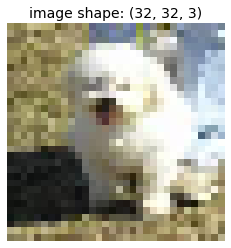

In [17]:
i = np.random.choice(len(X_tr))
show(X_tr[i])
print('True label: {0}'.format(classes[Y_tr[i]]))

In [18]:
X_tr_scaled, X_val_scaled, scaler = scale_data(X_tr, X_val, return_scaler=True)

### II - B) Design and train a ConvNet from scratch

**Exercice**

- Implement a Convolutional Network using the Keras Sequential API
- Typically, you would use series of convolutional blocs: 

`
model.add(Conv2D(output_filter, (kernel_height, kernel_width), padding, input_shape=(input_height, input_width, input_filter)))
model.add(Activation(activation))
model.add(BatchNormalization())
`
- Usually, the output_filter size grows accross the network
- End the network with a `Flatten` layer followed by a final `Dense` layer
- Be careful with the shapes accross the network, the activation functions used, the optimizer, and the loss function
- Don't forget to use Dropout layers to avoid overfitting issues

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

def design_and_compile_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # Compiling the model adds a loss function, optimiser and metrics to track during training
    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [20]:
design_and_compile_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [21]:
batch_size = 128
num_epochs = 20  # The number of epochs (full passes through the data) to train for

model = design_and_compile_model()

# The fit function allows you to fit the compiled model to some training data
model_history = model.fit(
    x=X_tr_scaled, 
    y=Y_tr, 
    batch_size=batch_size, 
    epochs=num_epochs,
    verbose=1,
    validation_data=(X_val_scaled, Y_val)
)
print('Training complete')

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 24s 3ms/sample - loss: 0.8986 - accuracy: 0.6075 - val_loss: 0.8018 - val_accuracy: 0.5088
Epoch 2/20
7500/7500 [==============================] - 24s 3ms/sample - loss: 0.7181 - accuracy: 0.6597 - val_loss: 0.7359 - val_accuracy: 0.5356
Epoch 3/20
7500/7500 [==============================] - 24s 3ms/sample - loss: 0.6368 - accuracy: 0.6921 - val_loss: 1.1739 - val_accuracy: 0.5088
Epoch 4/20
7500/7500 [==============================] - 23s 3ms/sample - loss: 0.5980 - accuracy: 0.7103 - val_loss: 0.8064 - val_accuracy: 0.5356
Epoch 5/20
7500/7500 [==============================] - 21s 3ms/sample - loss: 0.5373 - accuracy: 0.7412 - val_loss: 0.5697 - val_accuracy: 0.7036
Epoch 6/20
7500/7500 [==============================] - 22s 3ms/sample - loss: 0.4968 - accuracy: 0.7704 - val_loss: 1.0434 - val_accuracy: 0.5528
Epoch 7/20
7500/7500 [==============================] - 22s 3ms/sample

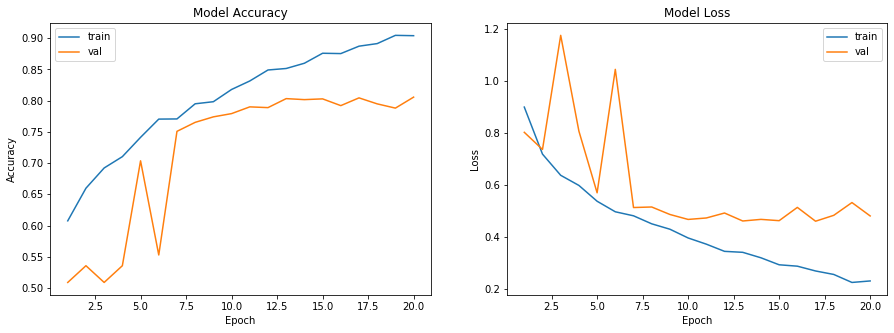

In [22]:
plot_model_history(model_history)

### II - C) Improve it using data augmentation

**Exercice**

- Try to improve the effectiveness of your network using some Data Augmentation
- Basically, it consists in building a `ImageDataGenerator` fitted on your training dataset
- Then you will be able to generate new consistent samples, and refit your model using the `fit_generator` Keras method

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=lambda x: apply_scaling(x, scaler)
    )
data_generator.fit(X_tr)

In [24]:
model = design_and_compile_model()

model_history = model.fit_generator(data_generator.flow(X_tr, Y_tr, batch_size=batch_size), \
                    steps_per_epoch=len(X_tr) // batch_size, epochs=20, \
                    verbose=1, validation_data=(apply_scaling(X_val, scaler), Y_val))

Epoch 1/20
58/58 [==============================] - 30s 523ms/step - loss: 0.9155 - accuracy: 0.5956 - val_loss: 0.7495 - val_accuracy: 0.5084
Epoch 2/20
58/58 [==============================] - 28s 476ms/step - loss: 0.7479 - accuracy: 0.6352 - val_loss: 0.8894 - val_accuracy: 0.5116
Epoch 3/20
58/58 [==============================] - 28s 476ms/step - loss: 0.7072 - accuracy: 0.6519 - val_loss: 0.8207 - val_accuracy: 0.5228
Epoch 4/20
58/58 [==============================] - 27s 472ms/step - loss: 0.6551 - accuracy: 0.6697 - val_loss: 0.7773 - val_accuracy: 0.5536
Epoch 5/20
58/58 [==============================] - 28s 484ms/step - loss: 0.6450 - accuracy: 0.6751 - val_loss: 0.5866 - val_accuracy: 0.6996
Epoch 6/20
58/58 [==============================] - 27s 463ms/step - loss: 0.6113 - accuracy: 0.6926 - val_loss: 0.5715 - val_accuracy: 0.6952
Epoch 7/20
58/58 [==============================] - 27s 469ms/step - loss: 0.5848 - accuracy: 0.7063 - val_loss: 0.5414 - val_accuracy: 0.7232

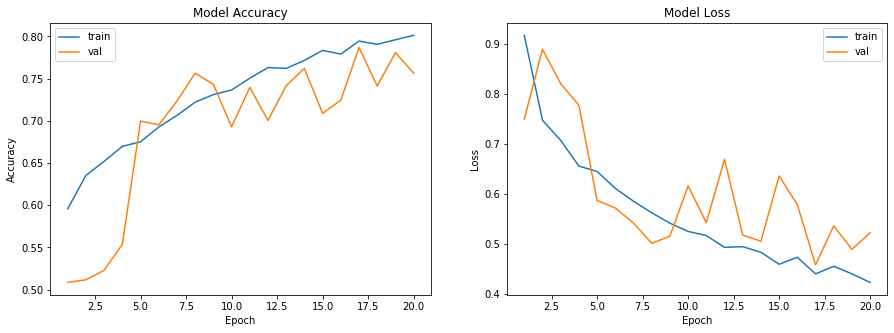

In [25]:
plot_model_history(model_history)

# III - Transfer learning

Objectives:
- Classify an image by loading a pre-trained ResNet50 model using Keras Zoo
    - No training required
    - Decode an ImageNet prediction
- Build a headless model and compute representations of images 
    - Retrain a model from representations of images for your own classification task: here cat vs dog dataset

In [26]:
cat_sample_path = "data/cat/cat_1.jpg"
dog_sample_path = "data/dog/dog_1.jpg"
resnet_input_size = (224, 224)

In [27]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from skimage.transform import resize
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions

model_ResNet50 = ResNet50(include_top=True, weights='imagenet')
model_ResNet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### III - A) Classify of an image using pre-trained weights

**Exercise**
- Open an image, preprocess it and build a batch of 1 image
- Use the model to classify this image
- Decode the predictions using `decode_predictions` from Keras

Notes:
- You may use `preprocess_input` for preprocessing the image. 
- Test your code with `"data/cat/cat_1.jpg"` 
- ResNet has been trained on (width, height) images of (224,224) and range of pixel intensities in `[0, 255]`.
    - [skimage.transform.resize](http://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.resize) has a `preserve_range` keyword useful in that matter 

Egyptian_cat 0.18210718
bucket 0.1297617
tiger_cat 0.11986422
tabby 0.07753436
hamper 0.049348887


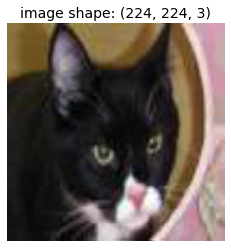

In [28]:
img = imread(cat_sample_path)
img_resized = resize(img, resnet_input_size, mode='reflect', preserve_range=True)
show(img_resized)

img_batch = preprocess_input(np.expand_dims(img_resized, axis=0)) 
predictions = model_ResNet50.predict(img_batch)
decoded_predictions = decode_predictions(predictions)

for _, name, score in decoded_predictions[0]:
    print(name, score)

### III - B) Build a headless model and compute representations of images

- Model has $177$ layers
- See where we should stop to have the extracted feature and start building a new classficlation model from here

In [29]:
print(len(model_ResNet50.layers))

177


- Let's remove the last dense classification layer that is specific 
to the image net classes and use the previous layers (after flattening) as a feature extractors
- Use ResNet input layer and last layer of extracted features to build a feature extractor model
    - Use Keras functional API

In [30]:
# Create a truncated Model using ResNet50.input and the before last layer
output = model_ResNet50.layers[-2].output
feat_extractor_model = Model(model_ResNet50.input, output)

When using this model we need to be careful to apply the same image processing as was used during the training, otherwise the marginal distribution of the input pixels might not be on the right scale:

In [31]:
def preprocess_resnet(x, size):
    x = resize(x, size, mode='reflect', preserve_range=True)
    x = np.expand_dims(x, axis=0)
    if x.ndim == 3:
        x = np.expand_dims(x, axis=0)
    return preprocess_input(x)

This model extracts high level concepts from any image that has been preprocessed like the images ResNet trained on.
The model transforms a preprocessed (224, 224) RGB image into a long vector of activations.
Each activation refers to some concept statistically connected to a bunch of different classes.

In [32]:
cat_img = imread(cat_sample_path)
cat_img_processed = preprocess_resnet(cat_img, resnet_input_size)
cat_representation = feat_extractor_model.predict(cat_img_processed)
print("Cat deep representation shape: (%d, %d)" % cat_representation.shape)
cat_representation_df = pd.DataFrame(np.ravel(cat_representation), columns=['cat_deep_features'])
cat_representation_df

Cat deep representation shape: (1, 2048)


,cat_deep_features
0,0.385339
1,0.246873
2,0.094833
3,0.843254
4,1.027586
...,...
2043,0.092768
2044,0.301268
2045,0.486970
2046,0.690678


**Questions**
- What is the number of $0$s in the cat representation vector?

<span style="color:green">
$182$ zeros found in the cat representation vector. That is $8.89\%$ of all activations
</span>

- Can you find any negative values?

<span style="color:green">
No negative values found at this stage
</span>

- Why are there $0$ values ? What does it mean?

<span style="color:green">
As mentioned above, each activation refers to some concept statistically connected to a bunch of different classes. A $0$ activation, or close to $0$, means that the high-level concept being looked for by the network in not found in the image
</span>

- Extract ResNet representations of other dogs and cats. Are the zeros at the same places in vector? Explain why or give an intuition of it

<span style="color:green">
Distributions of $0s$ activations are different for dogs and cats.  
That is because to make the difference between these $2$ classes there are concepts that are  specific to dogs or cats. That is concepts for which $p(dog|concept)\approx1$ and $p(cat|concept)\approx0$ or $p(cat|concept)\approx1$ and $p(dog|concept)\approx0$
Thus concepts likely to be there for a class and not the other, leading to $0$ activations at some indexes for a class and not the other
</span>

In [33]:
print("**Number of 0s in the cat representation vector**")
nb_zeros = sum(np.ravel(cat_representation) == 0)
print(nb_zeros, "zeros")
print("{:.2f}% of zeros".format(nb_zeros/float(len(np.ravel(cat_representation)))*100))

print("**Number of negative values in the cat representation vector**")
nb_negative_values = sum(np.ravel(cat_representation) < 0)
print(nb_negative_values, "negative values")

**Number of 0s in the cat representation vector**
156 zeros
7.62% of zeros
**Number of negative values in the cat representation vector**
0 negative values


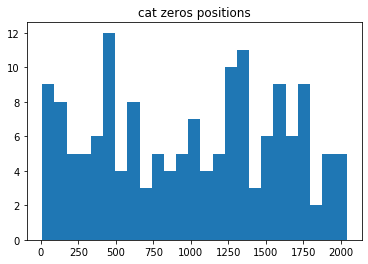

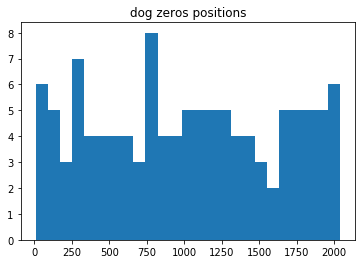

In [34]:
plt.hist(np.where(cat_representation == 0)[1], bins=25)
plt.title("cat zeros positions")
plt.show()

dog_img = imread(dog_sample_path)
dog_img_processed = preprocess_resnet(dog_img, resnet_input_size)
dog_representation = feat_extractor_model.predict(dog_img_processed)

plt.hist(np.where(dog_representation == 0)[1], bins=25)
plt.title("dog zeros positions")
plt.show()

### III - C) Retrain a model from computed representations of images

For this session we are going to use the dataset of the dogs-vs-cats we already used in part $2$.

In [35]:
classes = ['cat', 'dog']
X_tr, X_val, Y_tr, Y_val = get_splitted_data_with_size(
    image_size=(224, 224, 3), sample_size=2000, test_ratio=0.25, classes=classes, seed=42
)

**Questions**
- Inference time takes a long time only for $2000$ images. Explain why it would be much faster using a GPU
    
<span style="color:green">
GPU allows to perform parallel computing.
Most of the work during inference is about computing convolutions. Each convolution operation in a convolution layer is independant from the others. That means its outcome doesn't depend on the outcome of the others. All convolution operations could theoretically be performed at the same time to produce the feature map. Thus convolution layers are highly parallelizable and suit GPU usage
</span>

In [36]:
X_extracted_tr = feat_extractor_model.predict(preprocess_input(X_tr), verbose=1)
X_extracted_val = feat_extractor_model.predict(preprocess_input(X_val), verbose=1)
print('Done extracting resnet50 features..')

500/500 [==============================] - 28s 57ms/sample
Done extracting resnet50 features..


- Define a classification model fed with the newly created X and Y. <br>Remember that X is now a set of ResNet representations of the images
- Use either functional of sequential Keras apis
- Display training and validation accuracies

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import Adam

n_features = X_extracted_tr.shape[1]
transfer_model = Sequential()
transfer_model.add(Dropout(0.4))
transfer_model.add(Dense(1, input_dim=n_features, activation='sigmoid'))
transfer_model.compile(optimizer=Adam(),
                  loss='binary_crossentropy', metrics=['accuracy'])
transfer_model.fit(X_extracted_tr, Y_tr,
              validation_data=(X_extracted_val, Y_val),
              verbose=1, epochs=30)

Train on 1500 samples, validate on 500 samples
Epoch 1/30
1500/1500 [==============================] - 0s 299us/sample - loss: 0.4202 - accuracy: 0.8053 - val_loss: 0.1979 - val_accuracy: 0.9220
Epoch 2/30
1500/1500 [==============================] - 0s 58us/sample - loss: 0.2325 - accuracy: 0.8953 - val_loss: 0.1674 - val_accuracy: 0.9260
Epoch 3/30
1500/1500 [==============================] - 0s 57us/sample - loss: 0.1931 - accuracy: 0.9187 - val_loss: 0.1787 - val_accuracy: 0.9240
Epoch 4/30
1500/1500 [==============================] - 0s 55us/sample - loss: 0.1584 - accuracy: 0.9347 - val_loss: 0.1526 - val_accuracy: 0.9360
Epoch 5/30
1500/1500 [==============================] - 0s 58us/sample - loss: 0.1491 - accuracy: 0.9347 - val_loss: 0.1534 - val_accuracy: 0.9420
Epoch 6/30
1500/1500 [==============================] - 0s 53us/sample - loss: 0.1320 - accuracy: 0.9487 - val_loss: 0.1635 - val_accuracy: 0.9460
Epoch 7/30
1500/1500 [==============================] - 0s 59us/sample

**Questions**
- How high in validation accuracy did you get? 
- Compare to your previous classification model in part 2. Does it perform worse? Better? Why?

<span style="color:green">
Compared to the previous model, this one performs much better. That is due to the concepts extracted by resnet. They are all relevant with respect to some classes, there are no concept looked for in the images that is pure noise. 
The extraction itself from resnet of the main concepts for our predictions task is of much better quality and generalizable since it has been obtained from training on a huge dataset of millions of images that match better the actual distribution
</span>

- Did you observe overfitting during training? Why? If yes, what did you do to avoid it?

<span style="color:green">
Regularization techniques like dropout must be used to prevent the model from relying on data patterns only found in training set
</span>